In [134]:
##### Part 0: housekeeping 
import csv
import pandas as pd
import copy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%pprint

Pretty printing has been turned OFF


In [133]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
def rearrange_col(dataframe, col_to_move, reference_col, right=True):
    col_list = dataframe.columns.values.tolist()
    col_list2 = [x for x in col_list if x != col_to_move]
    reference_idx = col_list2.index(reference_col)
    if right==True:
        col_list3 = []
        for y in col_list2:
            col_list3.append(y)
            if y == reference_col:
                col_list3.append(col_to_move)
        return dataframe[col_list3]
    else:
        col_list3 = []
        for y in col_list2:
            col_list3.append(y)
            if y == reference_col:
                col_list3.insert(-2, col_to_move)
        return  dataframe[col_list3]

In [4]:
def PopSamples(pool, num_subset):
    np.random.shuffle(pool)
    return pool[:num_subset]

In [441]:
def ttest_is_significant (series1, series2, threshold=0.05, equal_var=False):
    #statistic = stats.ttest_ind(series1, series2, equal_var=equal_var).statistic
    #pvalue = stats.ttest_ind(series1, series2, equal_var=equal_var).pvalue
    ret = stats.ttest_ind(series1, series2, equal_var=equal_var)
    #print (ret.pvalue)
    if ret.pvalue > threshold: 
        result = 1  # pass, i.e, 'Insignificant'
    else:
        result = 0  # fail, i.e, 'Significantly different distribution'
    #print (result)
    return result

In [508]:
def choose_top_cat(crosstab, n):
    crosstab2 = crosstab.drop(index='other')
    ct_top = crosstab2.iloc[1:1+n, :]
    return ct_top

In [548]:
def find_subset_semantic_category(listfile, df, totalN, semcategoryN, max_try=10000): 
    '''df=pd.read_excel(filename)'''
    import ast
    file_id = listfile.split('/')[-1].split('_list')
    file = open(listfile, "r")
    contents = file.read()
    dic = ast.literal_eval(contents)
    verbs_matched = dic['unergative'] + dic['unaccusative'] + dic['transitive']
    #print ('verb_matched', len(verbs_matched))

    df = df.rename(columns={"SemClass_Consensus": "SemClass", "AspClass_Consensus": "AspClass"})
    column_to_drop = ['word', 'unerg_pb', 'unacc_pb', 'tr_pb', 'totalN_pb', 'most_frequent_pb', 'intr_g', 'tr_g', \
              'totalN_g', 'most_frequent_g', 'intr_google', 'trans_google', 'google1950_intrans', \
              'google1950_trans', 'google_5gram_intrans', 'google_5gram_trans', 'SemanticType_JB', \
              'SemanticType_JB_edit', 'Typicality_JB', 'SemanticType_LC', 'Typicality_LC', 'CONSENSUS_JB']
    df.drop(columns=column_to_drop, inplace=True)
    df_avail = df.loc[df['in']==1]
    print ('df_avail', df_avail.shape)
    allverbs = df_avail['Lemma'].tolist()
    print ('# of all available verbs:', len(allverbs))

    df['in'] = ''
    df['syn_matched']=''
    df = rearrange_col(df, 'syn_matched', 'in')
    df['in'] = np.where(df['Lemma'].isin(verbs_matched), 1, 0)
    df['matched'] = np.where(df['Lemma'].isin(verbs_matched), 1, 0)
    df.drop(columns=['Index'], inplace=True)

    extraN = totalN - len(verbs_matched)
    verbs_remaining = [i for i in allverbs if i not in verbs_matched]
    semclass = set(df_avail['SemClass'].tolist())
    semclass_all = {} #### for raw_in
    for semcl in semclass:
        semclass_all[semcl] = df_avail.loc[df_avail['SemClass']==semcl]['Lemma'].tolist()

    cols_test = ['LogFreqHAL', 'AgeofAcqsn', 'Length', 'Ortho_N', 'Phono_N', 'OLD', 'PLD', 'NPhon', 'NSyll', \
                 'I_Mean_RT', 'I_Mean_Accuracy', 'I_NMG_Mean_RT', 'I_NMG_Mean_Accuracy', 'N2_F', 'N3_F']

    from tqdm.notebook import tqdm as tqdm
    tqdm().pandas()

    success_n = 0 
    nearly_good_n = 0
    for attempt_n in tqdm(range(max_try)):
        verbs_extra = PopSamples(verbs_remaining, extraN)
        verbs_final = verbs_matched + verbs_extra
        df['in'] = np.where(df['Lemma'].isin(verbs_final), 1, 0)
        df_chosen = df.loc[df['in']==1]
        semclass_chosen = {}
        for semcl in semclass:
            semclass_chosen[semcl] = df_chosen.loc[df_chosen['SemClass']==semcl]['Lemma'].tolist()
#         semclass_pool = {}
#         for k, v in semclass_all.items():
#             semclass_pool[k] = [i for i in v if i not in semclass_chosen[k]]
        ct_sem = pd.crosstab(df_chosen.SemClass, df_chosen.SynClassNew, margins=True).sort_values(by='All', ascending=False)
        top_label = choose_top_cat(ct_sem, semcategoryN).index.tolist()
        pairs = list(itertools.combinations(top_label, 2))

        #test_dic = {}
        take = 1
        result_log = []
        for i in range(0, len(cols_test)):
            for p in pairs:
                series1 = df_chosen.loc[df_chosen['SemClass']==p[0]][cols_test[i]].tolist()
                series2 = df_chosen.loc[df_chosen['SemClass']==p[1]][cols_test[i]].tolist()
                r=ttest_is_significant(series1, series2, equal_var=False)
                result_log.append(r)
                take *= r
        fail_n = result_log.count(0)
        if fail_n < len(cols_test)*len(pairs) * 0.1:
            print ('Attempt', attempt_n, ' has failed ', fail_n, 'times')
            
        if fail_n < 6:
            nearly_good_n += 1
            df.to_excel('./%s_nearlygood_list%d.xlsx' %(file_id, nearly_good_n))

        if take: 
            success_n += 1
            print ('set %d found' %success_n)
#             for k, v in semclass_chosen.items():
#                 print (k, len(v))
            for k in sorted(semclass_chosen, key=lambda k: len(semclass_chosen[k]), reverse=True):
                print (k, len(semclass_chosen[k]))
            df.to_excel('./%s_list%d.xlsx' %(file_id, success_n))


In [ ]:
li = '/Users/songheekim/Google Drive/Primary/Projects/VerbVector/Verblists/returnedlists_4gram/50_55_55_list1.txt'
raw = pd.read_excel('/Users/songheekim/Google Drive/Primary/Projects/VerbVector/Verblists/verblist_v3.0_45gram_cleancandidatesforpermutation.xlsx')

find_subset_semantic_category(li, raw, 240, 5, max_try=10000)

df_avail (403, 34)
# of all available verbs: 403



Attempt 873  has failed  10 times
Attempt 2375  has failed  11 times
Attempt 2893  has failed  12 times
Attempt 3320  has failed  13 times
Attempt 4044  has failed  13 times
Attempt 4558  has failed  12 times
Attempt 5264  has failed  14 times
Attempt 5560  has failed  13 times
Attempt 9233  has failed  14 times


In [ ]:
##### check if syntactic classes are met for low-level qualities 

# raw = pd.read_excel('/Users/songheekim/Google Drive/Primary/Projects/VerbVector/Verblists/verblist_v3.0_45gram_cleancandidatesforpermutation.xlsx')
# list1 = '/Users/songheekim/Google Drive/Primary/Projects/VerbVector/Verblists/returnedlists_4gram/50_55_55_list1.txt'

# file = open(list1, "r")
# contents = file.read()
# dic = ast.literal_eval(contents)
# unergative = raw.loc[raw['Lemma'].isin(dic['unergative'])]
# unaccusative = raw.loc[raw['Lemma'].isin(dic['unaccusative'])]
# transitive = raw.loc[raw['Lemma'].isin(dic['transitive'])]

# print ('unergative', unergative.shape)
# print ('unaccusative', unaccusative.shape)
# print ('transitive', transitive.shape)

# cols_test = ['LogFreqHAL', 'AgeofAcqsn', 'Length', 'Ortho_N', 'Phono_N', 'OLD', 'PLD', 'NPhon', 'NSyll', \
#              'I_Mean_RT', 'I_Mean_Accuracy', 'I_NMG_Mean_RT', 'I_NMG_Mean_Accuracy', 'N2_F', 'N3_F']

# for i in range(len(cols_test)):
#     print (cols_test[i])
#     print(ttest_is_significant(unergative[cols_test[i]].tolist(), unaccusative[cols_test[i]].tolist()))
#     print(ttest_is_significant(unaccusative[cols_test[i]].tolist(), transitive[cols_test[i]].tolist()))
#     print(ttest_is_significant(unergative[cols_test[i]].tolist(), transitive[cols_test[i]].tolist()))

In [473]:
unergative['LogFreqHAL'].tolist()

[10.891, 10.432, 10.407, 10.289, 8.097, 10.198, 9.243, 8.666, 8.656, 8.54, 8.175, 8.079, 8.058, 8.049, 8.045, 7.878, 7.832, 7.665, 7.585, 7.58, 7.56, 7.473, 7.41, 7.365, 7.308, 7.152, 6.836, 6.717, 6.687, 6.646, 6.597, 6.594, 6.544, 6.507, 6.486, 6.412, 6.378, 6.346, 6.292, 6.078, 6.073, 6.059, 5.875, 5.793, 5.67, 5.624, 5.525, 5.412, 5.407, 5.357]

In [439]:
raw = pd.read_excel('/Users/songheekim/Google Drive/Primary/Projects/VerbVector/Verblists/verblist_v3.0_45gram_cleancandidatesforpermutation.xlsx')
raw = raw.rename(columns={"SemClass_Consensus": "SemClass", "AspClass_Consensus": "AspClass"})

column_to_drop = ['word', 'Index', 'unerg_pb', 'unacc_pb', 'tr_pb', 'totalN_pb', 'most_frequent_pb', 'intr_g', 'tr_g', 'totalN_g',\
                  'most_frequent_g', 'intr_google', 'trans_google', 'google1950_intrans', 'google1950_trans',\
                 'google_5gram_intrans', 'google_5gram_trans', 'SemanticType_JB', 'SemanticType_JB_edit', \
                  'Typicality_JB', 'SemanticType_LC', 'Typicality_LC', 'CONSENSUS_JB']

raw.drop(columns=column_to_drop, inplace=True)


raw_avail = raw.loc[raw['in']==1] ###raw_avail: all items that are available for constructing a set
allverbs = raw_avail['Lemma'].tolist()
print ('the # of all available verbs:', len(allverbs))

the # of all available verbs: 403


In [440]:
raw.head()

,Lemma,GrandIndex,Index,in,LogFreqHAL,Concreteness,AgeofAcqsn,Database,Trans_Intrans,SynClassLitrt,SynClassSK,SynClassNew,good,Note,google1950_45gram_intrans,google1950_45gram_trans,AspClass,SemClass,SemanticTypeLevin,SemanticTypeEntry,Percentage_dom_PoS,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
0,run,3,3,1,12.316,4.31,4.47,CREA,both,unergative,unergative,unergative,unergative,NaN,66.50,33.50,Process,manner of motion,"verbs of creating and transformation, verbs of existence, verbs of existence, verbs of motion","26.3prepare, 47.5.1swarm, 47.7meander, 51.3.2run",0.89,3,19,40,1.00,1.00,3,1,596.647,1.00,559.955,1.000,386.53,229.70
1,live,5,5,1,11.763,3.57,6.10,CREA,intransitive only,unergative/unaccusative,unergative,unergative,unergative,NaN,91.49,8.51,State,existence,"verbs of ingesting, lodge verbs, verbs of existence","39.6gorge, 46lodge, 47.1exist",0.89,4,16,21,1.15,1.25,3,1,629.886,1.00,553.769,0.963,3645.64,606.44
2,speak,7,7,1,10.891,3.7,3.56,CREA,both,unergative,unergative,unergative,unergative,NaN,84.50,15.50,Process,communication,verbs of communication,37.5talk,1.00,5,4,12,1.70,1.30,4,1,598.719,1.00,645.130,1.000,973.45,284.91
3,listen,8,8,1,10.432,3.47,5.40,CREA,intransitive only,NaN,unergative,unergative,unergative,NaN,98.81,1.19,Process,perception,"verbs of perception, verbs of searching","30.3peer, 35.5rummage",1.00,6,2,6,1.85,1.65,4,2,526.455,0.97,576.520,1.000,1596.62,306.11
4,walk,9,9,1,10.407,4.07,3.45,CREA,both,unergative,unergative,unergative,unergative,NaN,89.75,10.25,Process,manner of motion,verbs of motion,51.3.2run,0.79,4,9,17,1.70,1.25,3,1,580.576,0.97,540.607,1.000,1288.42,315.70


In [401]:
###load candidate list
list1 = '/Users/songheekim/Google Drive/Primary/Projects/VerbVector/Verblists/returnedlists_4gram/50_55_55_list1.txt'

##load a dict from list
import ast
file = open(list1, "r")
contents = file.read()
dic = ast.literal_eval(contents)

In [445]:
list1.split('/')[-1].split('_list')

['50_55_55', '1.txt']

In [275]:
###we are going to construct a new spreadsheet where 'in'=1 if it appears in the 'list' & 'good'=1 if it's matched.

In [402]:
raw.head()

,Lemma,word,GrandIndex,Index,in,LogFreqHAL,Concreteness,AgeofAcqsn,Database,Trans_Intrans,SynClassLitrt,SynClassSK,SynClassNew,good,unerg_pb,unacc_pb,tr_pb,totalN_pb,most_frequent_pb,intr_g,tr_g,totalN_g,most_frequent_g,Note,intr_google,trans_google,google1950_intrans,google1950_trans,google1950_45gram_intrans,google1950_45gram_trans,google_5gram_intrans,google_5gram_trans,AspClass_Consensus,SemanticType_JB,SemanticType_JB_edit,Typicality_JB,SemanticType_LC,Typicality_LC,SemClass_Consensus,CONSENSUS_JB,SemanticTypeLevin,SemanticTypeEntry,Percentage_dom_PoS,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
0,run,run,3,3,1,12.316,4.31,4.47,CREA,both,unergative,unergative,unergative,unergative,18.0,34.00,44.0,374.0,tr,NaN,NaN,NaN,NaN,NaN,76.27,23.65,71.00,29.00,66.50,33.50,69.71,30.29,Process,body mvt or posture,body movement or posture,5.0,manner of motion,5.0,manner of motion,manner of motion,"verbs of creating and transformation, verbs of existence, verbs of existence, verbs of motion","26.3prepare, 47.5.1swarm, 47.7meander, 51.3.2run",0.89,3,19,40,1.00,1.00,3,1,596.647,1.00,559.955,1.000,386.53,229.70
1,live,live,5,5,1,11.763,3.57,6.10,CREA,intransitive only,unergative/unaccusative,unergative,unergative,unergative,95.0,0.78,4.7,129.0,unerg,NaN,NaN,NaN,NaN,NaN,94.18,5.81,92.30,7.70,91.49,8.51,93.25,6.75,State,existence,existence,5.0,existence,5.0,existence,existence,"verbs of ingesting, lodge verbs, verbs of existence","39.6gorge, 46lodge, 47.1exist",0.89,4,16,21,1.15,1.25,3,1,629.886,1.00,553.769,0.963,3645.64,606.44
2,speak,speak,7,7,1,10.891,3.7,3.56,CREA,both,unergative,unergative,unergative,unergative,87.0,NaN,13.0,69.0,unerg,NaN,NaN,NaN,NaN,NaN,87.52,12.45,87.10,12.90,84.50,15.50,86.08,13.92,Process,communication,communication,5.0,communication,5.0,communication,communication,verbs of communication,37.5talk,1.00,5,4,12,1.70,1.30,4,1,598.719,1.00,645.130,1.000,973.45,284.91
3,listen,listen,8,8,1,10.432,3.47,5.40,CREA,intransitive only,NaN,unergative,unergative,unergative,91.0,NaN,8.8,34.0,unerg,NaN,NaN,NaN,NaN,NaN,98.93,1.07,98.09,1.91,98.81,1.19,98.55,1.45,Process,perception,perception,5.0,perception,4.0,perception,perception,"verbs of perception, verbs of searching","30.3peer, 35.5rummage",1.00,6,2,6,1.85,1.65,4,2,526.455,0.97,576.520,1.000,1596.62,306.11
4,walk,walk,9,9,1,10.407,4.07,3.45,CREA,both,unergative,unergative,unergative,unergative,88.0,NaN,10.0,48.0,unerg,NaN,NaN,NaN,NaN,NaN,92.09,7.88,91.45,8.55,89.75,10.25,89.92,10.08,Process,body mvt or posture,body movement or posture,5.0,body movement or posture,5.0,manner of motion,manner of motion,verbs of motion,51.3.2run,0.79,4,9,17,1.70,1.25,3,1,580.576,0.97,540.607,1.000,1288.42,315.70


In [403]:
raw['in'] = ''
raw['syn_matched']= ''
raw = rearrange_col(raw, 'syn_matched', 'in')

In [404]:
raw.head()

,Lemma,word,GrandIndex,Index,in,syn_matched,LogFreqHAL,Concreteness,AgeofAcqsn,Database,Trans_Intrans,SynClassLitrt,SynClassSK,SynClassNew,good,unerg_pb,unacc_pb,tr_pb,totalN_pb,most_frequent_pb,intr_g,tr_g,totalN_g,most_frequent_g,Note,intr_google,trans_google,google1950_intrans,google1950_trans,google1950_45gram_intrans,google1950_45gram_trans,google_5gram_intrans,google_5gram_trans,AspClass_Consensus,SemanticType_JB,SemanticType_JB_edit,Typicality_JB,SemanticType_LC,Typicality_LC,SemClass_Consensus,CONSENSUS_JB,SemanticTypeLevin,SemanticTypeEntry,Percentage_dom_PoS,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
0,run,run,3,3,,,12.316,4.31,4.47,CREA,both,unergative,unergative,unergative,unergative,18.0,34.00,44.0,374.0,tr,NaN,NaN,NaN,NaN,NaN,76.27,23.65,71.00,29.00,66.50,33.50,69.71,30.29,Process,body mvt or posture,body movement or posture,5.0,manner of motion,5.0,manner of motion,manner of motion,"verbs of creating and transformation, verbs of existence, verbs of existence, verbs of motion","26.3prepare, 47.5.1swarm, 47.7meander, 51.3.2run",0.89,3,19,40,1.00,1.00,3,1,596.647,1.00,559.955,1.000,386.53,229.70
1,live,live,5,5,,,11.763,3.57,6.10,CREA,intransitive only,unergative/unaccusative,unergative,unergative,unergative,95.0,0.78,4.7,129.0,unerg,NaN,NaN,NaN,NaN,NaN,94.18,5.81,92.30,7.70,91.49,8.51,93.25,6.75,State,existence,existence,5.0,existence,5.0,existence,existence,"verbs of ingesting, lodge verbs, verbs of existence","39.6gorge, 46lodge, 47.1exist",0.89,4,16,21,1.15,1.25,3,1,629.886,1.00,553.769,0.963,3645.64,606.44
2,speak,speak,7,7,,,10.891,3.7,3.56,CREA,both,unergative,unergative,unergative,unergative,87.0,NaN,13.0,69.0,unerg,NaN,NaN,NaN,NaN,NaN,87.52,12.45,87.10,12.90,84.50,15.50,86.08,13.92,Process,communication,communication,5.0,communication,5.0,communication,communication,verbs of communication,37.5talk,1.00,5,4,12,1.70,1.30,4,1,598.719,1.00,645.130,1.000,973.45,284.91
3,listen,listen,8,8,,,10.432,3.47,5.40,CREA,intransitive only,NaN,unergative,unergative,unergative,91.0,NaN,8.8,34.0,unerg,NaN,NaN,NaN,NaN,NaN,98.93,1.07,98.09,1.91,98.81,1.19,98.55,1.45,Process,perception,perception,5.0,perception,4.0,perception,perception,"verbs of perception, verbs of searching","30.3peer, 35.5rummage",1.00,6,2,6,1.85,1.65,4,2,526.455,0.97,576.520,1.000,1596.62,306.11
4,walk,walk,9,9,,,10.407,4.07,3.45,CREA,both,unergative,unergative,unergative,unergative,88.0,NaN,10.0,48.0,unerg,NaN,NaN,NaN,NaN,NaN,92.09,7.88,91.45,8.55,89.75,10.25,89.92,10.08,Process,body mvt or posture,body movement or posture,5.0,body movement or posture,5.0,manner of motion,manner of motion,verbs of motion,51.3.2run,0.79,4,9,17,1.70,1.25,3,1,580.576,0.97,540.607,1.000,1288.42,315.70


In [405]:
verbs_matched = dic['unergative'] + dic['unaccusative'] + dic['transitive']

In [406]:
len(verbs_matched)

160

In [407]:
### update raw['In']; 1 if Lemma in verbs_in, otherwise 0
raw['in'] = np.where(raw['Lemma'].isin(verbs_matched), 1, 0)
raw['syn_matched'] = np.where(raw['Lemma'].isin(verbs_matched), 1, 0)

In [408]:
raw.loc[raw['in']==1].shape

(160, 57)

In [409]:
raw.loc[raw['syn_matched']==1].shape

(160, 57)

In [410]:
raw = raw.sort_values(by=['in', 'syn_matched', 'SynClassNew', 'GrandIndex'], ascending=[False, False, True, True])

In [411]:
raw.drop(columns=['Index', 'word'], inplace=True)

In [414]:
#raw_avail.drop(columns=column_to_drop+['Index', 'in', 'word'], inplace=True)

In [21]:
#raw.columns.tolist()

In [415]:
raw_avail.head()

,Lemma,GrandIndex,LogFreqHAL,Concreteness,AgeofAcqsn,Database,Trans_Intrans,SynClassLitrt,SynClassSK,SynClassNew,good,Note,google1950_45gram_intrans,google1950_45gram_trans,AspClass_Consensus,SemClass_Consensus,SemanticTypeLevin,SemanticTypeEntry,Percentage_dom_PoS,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
0,run,3,12.316,4.31,4.47,CREA,both,unergative,unergative,unergative,unergative,NaN,66.50,33.50,Process,manner of motion,"verbs of creating and transformation, verbs of existence, verbs of existence, verbs of motion","26.3prepare, 47.5.1swarm, 47.7meander, 51.3.2run",0.89,3,19,40,1.00,1.00,3,1,596.647,1.00,559.955,1.000,386.53,229.70
1,live,5,11.763,3.57,6.10,CREA,intransitive only,unergative/unaccusative,unergative,unergative,unergative,NaN,91.49,8.51,State,existence,"verbs of ingesting, lodge verbs, verbs of existence","39.6gorge, 46lodge, 47.1exist",0.89,4,16,21,1.15,1.25,3,1,629.886,1.00,553.769,0.963,3645.64,606.44
2,speak,7,10.891,3.7,3.56,CREA,both,unergative,unergative,unergative,unergative,NaN,84.50,15.50,Process,communication,verbs of communication,37.5talk,1.00,5,4,12,1.70,1.30,4,1,598.719,1.00,645.130,1.000,973.45,284.91
3,listen,8,10.432,3.47,5.40,CREA,intransitive only,NaN,unergative,unergative,unergative,NaN,98.81,1.19,Process,perception,"verbs of perception, verbs of searching","30.3peer, 35.5rummage",1.00,6,2,6,1.85,1.65,4,2,526.455,0.97,576.520,1.000,1596.62,306.11
4,walk,9,10.407,4.07,3.45,CREA,both,unergative,unergative,unergative,unergative,NaN,89.75,10.25,Process,manner of motion,verbs of motion,51.3.2run,0.79,4,9,17,1.70,1.25,3,1,580.576,0.97,540.607,1.000,1288.42,315.70


In [416]:
matched = raw.loc[raw['syn_matched']==1]

In [417]:
print ('# of everything-except-freq-matched unergative:', matched.loc[raw['SynClassNew']=='unergative'].shape)
print ('# of everything-except-freq-matched unaccusative:', matched.loc[raw['SynClassNew']=='unaccusative'].shape)
print ('# of everything-except-freq-matched transitive:', matched.loc[raw['SynClassNew']=='transitive'].shape)

# of everything-except-freq-matched unergative: (50, 34)
# of everything-except-freq-matched unaccusative: (55, 34)
# of everything-except-freq-matched transitive: (55, 34)


In [25]:
#set(matched.loc[matched['SynClassNew']=='unaccusative']['good'].tolist())

In [418]:
# random select extra verbs to make a set of 200
extraN = 200 - len(verbs_matched)
verbs_remaining = [i for i in allverbs if i not in verbs_matched]
verbs_extra = PopSamples(verbs_remaining, extraN)
verbs_final = verbs_matched + verbs_extra 

In [419]:
len(verbs_final)

200

In [420]:
raw['in'] = np.where(raw['Lemma'].isin(verbs_final), 1, 0)

In [295]:
raw = raw.sort_values(by=['in', 'syn_matched', 'SynClassNew', 'GrandIndex'], ascending=[False, False, True, True])

In [30]:
#raw = raw.set_index('Lemma')

In [296]:
raw.head()

,Lemma,GrandIndex,in,syn_matched,LogFreqHAL,Concreteness,AgeofAcqsn,Database,Trans_Intrans,SynClassLitrt,SynClassSK,SynClassNew,good,Note,google1950_45gram_intrans,google1950_45gram_trans,AspClass_Consensus,SemClass_Consensus,SemanticTypeLevin,SemanticTypeEntry,Percentage_dom_PoS,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
171,change,97,1,1,11.965,2.89,4.26,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,35.09,64.91,Process,ch of state,"verbs of change of possession, verbs of creating and transformation, verbs of grooming and bodily care, verbs of change of state","13.6exchange, 26.6turn, 41.1.1dress, 45.4state",0.72,6,2,4,1.80,2.35,4,1,629.939,0.97,596.385,1.0,974.60,425.64
173,sell,100,1,1,11.255,3.35,7.05,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,34.85,65.15,Process,obj-directed action,verbs of change of possession,13.1give,0.99,4,12,40,1.20,1.00,3,1,641.758,0.97,670.520,1.0,3226.54,964.77
176,improve,112,1,1,10.003,1.82,7.47,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,13.84,86.16,Process,ch of state,verbs of change of state,45.4state,1.00,7,0,0,2.35,2.45,6,2,604.235,1.00,632.393,1.0,260.45,73.70
177,click,115,1,1,9.906,4.03,6.94,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,31.94,68.06,Semelfactive,obj-directed action,"verbs of involving the body, verbs of emission","40.3.2crane, 43.2bang",0.60,5,8,16,1.55,1.10,4,1,670.257,1.00,614.966,1.0,1670.75,126.03
186,smash,157,1,1,7.853,3.79,4.65,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,30.92,69.08,Achievement,obj-directed action,"verbs of throwing, verbs of contact by impact, verbs of contact by impact, verbs of change of state","17.1throw, 18.1hit, 18.4thud, 45.1break",0.72,5,3,3,1.75,1.70,4,1,572.471,1.00,657.897,1.0,730.45,216.04


In [32]:
#raw.to_excel('/Users/songheekim/Google Drive/Primary/Projects/VerbVector/Verblists/finlist1_50_55_55.xlsx', index='Lemma')

In [309]:
########### look into semantics ######### 
raw_final = raw.loc[raw['Lemma'].isin(verbs_final)]
semclass = set(raw['SemClass_Consensus'].tolist())

In [310]:
semclass

{'oral sound production', 'body movement or posture', 'perception', 'manner of motion', 'communication', 'other', 'obj-directed transfer', 'existence', 'emission', 'creation or destruction', 'emotion', 'ch of state', 'body process', 'ch of quantity or size', 'obj-directed action', 'appearance, disappearance, and occurrence', 'ch of appearance', 'social or interpersonal event', 'aspectual', 'ch of cohesiveness', 'ch of location', 'cognitive event'}

In [311]:
semclass_dic_avail = {} #### for raw_in
for semcl in semclass:
    semclass_dic_avail[semcl] = raw_avail.loc[raw_avail['SemClass_Consensus']==semcl]['Lemma'].tolist()
    
semclass_dic_final = {}
for semcl in semclass:
    semclass_dic_final[semcl] = raw_final.loc[raw_final['SemClass_Consensus']==semcl]['Lemma'].tolist()
    
semclass_dic_pool = {}
for k, v in semclass_dic_all.items():
    semclass_dic_pool[k] = [i for i in v if i not in semclass_dic_final[k]]

In [312]:
#semclass_dic_avail['ch of location']

In [313]:
#ttest_is_significant (series1, series2, threshold=0.05, equal_var=False)

In [314]:
semclass_dic_final['existence']

['stay', 'remain', 'thrive', 'abound', 'flourish', 'prosper', 'prevail']

In [315]:
raw_final.head()

,Lemma,GrandIndex,in,syn_matched,LogFreqHAL,Concreteness,AgeofAcqsn,Database,Trans_Intrans,SynClassLitrt,SynClassSK,SynClassNew,good,Note,google1950_45gram_intrans,google1950_45gram_trans,AspClass_Consensus,SemClass_Consensus,SemanticTypeLevin,SemanticTypeEntry,Percentage_dom_PoS,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
171,change,97,1,1,11.965,2.89,4.26,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,35.09,64.91,Process,ch of state,"verbs of change of possession, verbs of creating and transformation, verbs of grooming and bodily care, verbs of change of state","13.6exchange, 26.6turn, 41.1.1dress, 45.4state",0.72,6,2,4,1.80,2.35,4,1,629.939,0.97,596.385,1.0,974.60,425.64
173,sell,100,1,1,11.255,3.35,7.05,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,34.85,65.15,Process,obj-directed action,verbs of change of possession,13.1give,0.99,4,12,40,1.20,1.00,3,1,641.758,0.97,670.520,1.0,3226.54,964.77
176,improve,112,1,1,10.003,1.82,7.47,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,13.84,86.16,Process,ch of state,verbs of change of state,45.4state,1.00,7,0,0,2.35,2.45,6,2,604.235,1.00,632.393,1.0,260.45,73.70
177,click,115,1,1,9.906,4.03,6.94,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,31.94,68.06,Semelfactive,obj-directed action,"verbs of involving the body, verbs of emission","40.3.2crane, 43.2bang",0.60,5,8,16,1.55,1.10,4,1,670.257,1.00,614.966,1.0,1670.75,126.03
186,smash,157,1,1,7.853,3.79,4.65,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,30.92,69.08,Achievement,obj-directed action,"verbs of throwing, verbs of contact by impact, verbs of contact by impact, verbs of change of state","17.1throw, 18.1hit, 18.4thud, 45.1break",0.72,5,3,3,1.75,1.70,4,1,572.471,1.00,657.897,1.0,730.45,216.04


In [369]:
ct_sem = pd.crosstab(raw_final.SemClass_Consensus, raw_final.SynClassNew, margins=True).sort_values(by='All', ascending=False)

def choose_top_cat(crosstab, n):
    crosstab2 = crosstab.drop(index='other')
    ct_top = crosstab2.iloc[1:1+n, :]
    return ct_top

top_label = choose_top_cat(ct_sem, 5).index.tolist()

In [370]:
top_label

['manner of motion', 'ch of state', 'obj-directed action', 'social or interpersonal event', 'body process']

In [ ]:
# #item_to_add = ['go', 'lie', 'stand', 'tear']
# for i in item_to_add:
#     raw_in.loc[i, 'in'] = 1

In [ ]:
#########CODE FOR T-TEST! (check if conditions are met)

In [399]:
#raw_in = raw_final.loc[raw_final['in'] == 1] ### necessary if further adjustments were made

sem_series_dict  = {}
for t in top_label:
    sem_series_dict[t] = {}
    for q in cols_to_keep[2:]:
        sem_series_dict[t][q] = raw_final.loc[raw_final['SemClass_Consensus']==t][q].tolist() 
        
pairs = list(itertools.combinations(top_label, 2))

for c in cols_to_keep[2:]: #for each low-level property 
    print ('===========', c, '============')
    for p in pairs:
        x = ttest_is_significant(raw_final.loc[raw_final['SemClass_Consensus']==p[0]][c].tolist(), \
                                 raw_final.loc[raw_final['SemClass_Consensus']==p[1]][c].tolist(), \
                                 threshold=0.05, equal_var=False)
        if x == 'significant':
            print (c, p, x)

=========== LogFreqHAL ============
LogFreqHAL ('manner of motion', 'obj-directed action') significant
LogFreqHAL ('manner of motion', 'social or interpersonal event') significant
LogFreqHAL ('obj-directed action', 'body process') significant
LogFreqHAL ('social or interpersonal event', 'body process') significant
=========== AgeofAcqsn ============
AgeofAcqsn ('manner of motion', 'ch of state') significant
AgeofAcqsn ('ch of state', 'body process') significant
=========== Length ============
=========== Ortho_N ============
Ortho_N ('obj-directed action', 'social or interpersonal event') significant
=========== Phono_N ============
Phono_N ('manner of motion', 'social or interpersonal event') significant
Phono_N ('obj-directed action', 'social or interpersonal event') significant
=========== OLD ============
=========== PLD ============
PLD ('manner of motion', 'ch of state') significant
PLD ('ch of state', 'obj-directed action') significant
=========== NPhon ============
NPhon ('mann

In [398]:
# import itertools
# list(itertools.combinations(top_label, 2))

In [446]:
result_log = [0,0,0,1,1,1,1,1]

In [449]:
result_log.count(1)

5

In [450]:
pairs

[('manner of motion', 'ch of state'), ('manner of motion', 'obj-directed action'), ('manner of motion', 'social or interpersonal event'), ('manner of motion', 'body process'), ('ch of state', 'obj-directed action'), ('ch of state', 'social or interpersonal event'), ('ch of state', 'body process'), ('obj-directed action', 'social or interpersonal event'), ('obj-directed action', 'body process'), ('social or interpersonal event', 'body process')]

In [456]:
15 * len(pairs) * 0.2

True

In [317]:
all_sem_ct = pd.crosstab(raw_avail.SemClass_Consensus, raw_avail.SynClassNew, margins=True)

In [318]:
all_sem_ct.sort_values(by='All', ascending=False)

SynClassNew,failedtransitive,failedunergative,transitive,unaccusative,unergative,All
SemClass_Consensus,,,,,,
All,33,7,195,103,65,403
ch of state,0,0,23,20,0,43
obj-directed action,3,0,31,5,0,39
manner of motion,0,0,4,16,19,39
other,2,0,28,2,3,35
social or interpersonal event,4,2,20,1,2,29
cognitive event,5,1,18,2,3,29
emotion,4,0,13,0,2,19
communication,8,0,10,0,1,19


In [98]:
# nd_chofstate = raw_in.loc[raw_in['SemClass_Consensus']=='ch of state'][cols_to_keep]
# nd_objaction = raw_in.loc[raw_in['SemClass_Consensus']=='obj-directed action'][cols_to_keep]
# nd_mannerofmotion = raw_in.loc[raw_in['SemClass_Consensus']=='manner of motion'][cols_to_keep]
# nd_social = raw_in.loc[raw_in['SemClass_Consensus']=='social or interpersonal event'][cols_to_keep]
# nd_cognitive = raw_in.loc[raw_in['SemClass_Consensus']=='cognitive event'][cols_to_keep]
# nd_emotion = raw_in.loc[raw_in['SemClass_Consensus']=='emotion'][cols_to_keep]
# nd_communication = raw_in.loc[raw_in['SemClass_Consensus']=='communication'][cols_to_keep]
# nd_oralsound = raw_in.loc[raw_in['SemClass_Consensus']=='oral sound production'][cols_to_keep]
# nd_emotion = raw_in.loc[raw_in['SemClass_Consensus']=='emotion'][cols_to_keep]
# nd_bodyprocess = raw_in.loc[raw_in['SemClass_Consensus']=='body process'][cols_to_keep]
# nd_cohesiveness = raw_in.loc[raw_in['SemClass_Consensus']=='ch of cohesiveness'][cols_to_keep]
# nd_quantitysize = raw_in.loc[raw_in['SemClass_Consensus']=='ch of quantity or size'][cols_to_keep]
# nd_creation = raw_in.loc[raw_in['SemClass_Consensus']=='creation or destruction'][cols_to_keep]
# nd_existence = raw_in.loc[raw_in['SemClass_Consensus']=='existence'][cols_to_keep]
# nd_objtransfer = raw_in.loc[raw_in['SemClass_Consensus']=='obj-directed transfer'][cols_to_keep]
# nd_choflocation = raw_in.loc[raw_in['SemClass_Consensus']=='ch of location'][cols_to_keep]

In [93]:
semclass_tuple = []
for s in semclass:
    semclass_tuple.append((s, raw_in.loc[raw_in['SemClass_Consensus']==s][cols_to_keep]))

In [99]:
semclass_tuple

[('oral sound production',        Lemma     SemClass_Consensus  LogFreqHAL  AgeofAcqsn  Length  Ortho_N  \
7      laugh  oral sound production       9.507        3.79       5        2   
8      shout  oral sound production       8.097        4.72       5        8   
10       cry  oral sound production       9.492        2.78       3        7   
11      sing  oral sound production       9.298        3.47       4       16   
13    scream  oral sound production       8.914        4.20       6        1   
20      yell  oral sound production       8.108        3.83       4       10   
21      howl  oral sound production       8.079        5.55       4        6   
31   whisper  oral sound production       7.473        4.26       7        2   
37      weep  oral sound production       6.717        8.50       4        9   
48    squeal  oral sound production       6.378        7.00       6        1   
49    mumble  oral sound production       6.377        7.15       6        6   
52      wail 

In [116]:
for i in enumerate(semclass_tuple):
    print (i[1][0])

oral sound production
body movement or posture
perception
manner of motion
communication
other
obj-directed transfer
existence
emission
creation or destruction
emotion
ch of state
body process
ch of quantity or size
obj-directed action
appearance, disappearance, and occurrence
ch of appearance
social or interpersonal event
aspectual
ch of cohesiveness
ch of location
cognitive event


In [135]:
semclass_tuple[0][1]

,Lemma,SemClass_Consensus,LogFreqHAL,AgeofAcqsn,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
7,laugh,oral sound production,9.507,3.79,5,2,26,1.95,1.05,3,1,555.871,0.94,564.667,1.000,425.60,86.76
8,shout,oral sound production,8.097,4.72,5,8,18,1.55,1.45,3,1,619.152,0.94,637.107,1.000,2304.11,1039.28
10,cry,oral sound production,9.492,2.78,3,7,8,1.70,1.15,3,1,564.970,0.97,576.269,1.000,233.75,52.53
11,sing,oral sound production,9.298,3.47,4,16,31,1.00,1.00,3,1,596.657,1.00,673.111,1.000,1539.67,141.24
13,scream,oral sound production,8.914,4.20,6,1,7,1.80,1.65,5,1,607.485,0.94,691.583,0.960,593.13,110.34
20,yell,oral sound production,8.108,3.83,4,10,31,1.55,1.00,3,1,672.621,0.91,592.000,1.000,2994.24,921.69
21,howl,oral sound production,8.079,5.55,4,6,29,1.60,1.50,3,1,626.848,0.97,630.593,1.000,919.52,19.54
31,whisper,oral sound production,7.473,4.26,7,2,2,2.05,2.25,6,2,608.647,1.00,598.000,1.000,914.05,42.72
37,weep,oral sound production,6.717,8.50,4,9,25,1.45,1.10,3,1,593.303,0.97,558.958,1.000,4050.37,386.55
48,squeal,oral sound production,6.378,7.00,6,1,3,2.15,1.75,5,1,685.387,0.97,711.357,1.000,440.91,59.92


In [191]:
def Sort_Tuple(tup):
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1], reverse=True)  
    return tup  

# tup = [('rishav', 10), ('akash', 5), ('ram', 20), ('gaurav', 15)]  
# Sort_Tuple(tup)

In [211]:
def draw_lowlevel_distr_semclass(df, topN): 
    '''topN= only draw for the N semclasses with largest occurrences'''
    cols_to_keep = ['Lemma', 'SemClass_Consensus', 'LogFreqHAL', 'AgeofAcqsn', 'Length', 'Ortho_N', 'Phono_N',\
        'OLD', 'PLD', 'NPhon', 'NSyll', 'I_Mean_RT', 'I_Mean_Accuracy', 'I_NMG_Mean_RT', 'I_NMG_Mean_Accuracy', 'N2_F', 'N3_F'] 
    semclass = set(df['SemClass_Consensus'].tolist())
    semclass_count = []
    for s in semclass:
        semclass_count.append((s, df.loc[df['SemClass_Consensus']==s].shape[0]))
    ordered_semclass_count = Sort_Tuple(semclass_count)
    semclass_chosen = [i[0] for i in ordered_semclass_count[:topN]]
    
    class_n = len(semclass_chosen)
    semclass_tuple = []
    for s in semclass_chosen:
        semclass_tuple.append((s, df.loc[df['SemClass_Consensus']==s][cols_to_keep]))

    for j in range(2,len(cols_to_keep)):
        quality = cols_to_keep[j]
        fig, axis = plt.subplots(class_n)
        fig.subplots_adjust(bottom=0.5, top=2.5, hspace=1)
        for k in range(class_n):
            axis[k].hist(semclass_tuple[k][1].iloc[:, j].tolist())
            axis[k].set_title(semclass_tuple[k][1].iloc[:, j].name + ":" + semclass_tuple[k][0])

In [216]:
raw_final.head()

,GrandIndex,in,syn_matched,LogFreqHAL,Concreteness,AgeofAcqsn,Database,Trans_Intrans,SynClassLitrt,SynClassSK,SynClassNew,good,Note,google1950_45gram_intrans,google1950_45gram_trans,AspClass_Consensus,SemClass_Consensus,SemanticTypeLevin,SemanticTypeEntry,Percentage_dom_PoS,Length,Ortho_N,Phono_N,OLD,PLD,NPhon,NSyll,I_Mean_RT,I_Mean_Accuracy,I_NMG_Mean_RT,I_NMG_Mean_Accuracy,N2_F,N3_F
Lemma,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
change,97,1,1,11.965,2.89,4.26,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,35.09,64.91,Process,ch of state,"verbs of change of possession, verbs of creating and transformation, verbs of grooming and bodily care, verbs of change of state","13.6exchange, 26.6turn, 41.1.1dress, 45.4state",0.72,6,2,4,1.80,2.35,4,1,629.939,0.97,596.385,1.0,974.60,425.64
sell,100,1,1,11.255,3.35,7.05,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,34.85,65.15,Process,obj-directed action,verbs of change of possession,13.1give,0.99,4,12,40,1.20,1.00,3,1,641.758,0.97,670.520,1.0,3226.54,964.77
improve,112,1,1,10.003,1.82,7.47,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,13.84,86.16,Process,ch of state,verbs of change of state,45.4state,1.00,7,0,0,2.35,2.45,6,2,604.235,1.00,632.393,1.0,260.45,73.70
click,115,1,1,9.906,4.03,6.94,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,31.94,68.06,Semelfactive,obj-directed action,"verbs of involving the body, verbs of emission","40.3.2crane, 43.2bang",0.60,5,8,16,1.55,1.10,4,1,670.257,1.00,614.966,1.0,1670.75,126.03
smash,157,1,1,7.853,3.79,4.65,VerbNet,both,NaN,unaccusative,transitive,transitive,NaN,30.92,69.08,Achievement,obj-directed action,"verbs of throwing, verbs of contact by impact, verbs of contact by impact, verbs of change of state","17.1throw, 18.1hit, 18.4thud, 45.1break",0.72,5,3,3,1.75,1.70,4,1,572.471,1.00,657.897,1.0,730.45,216.04


In [217]:
raw_final = raw_final.reset_index()

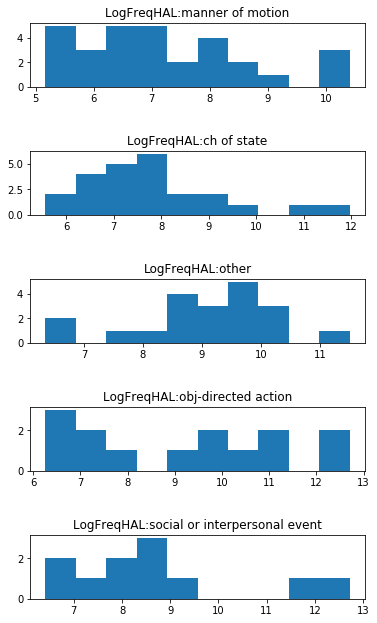

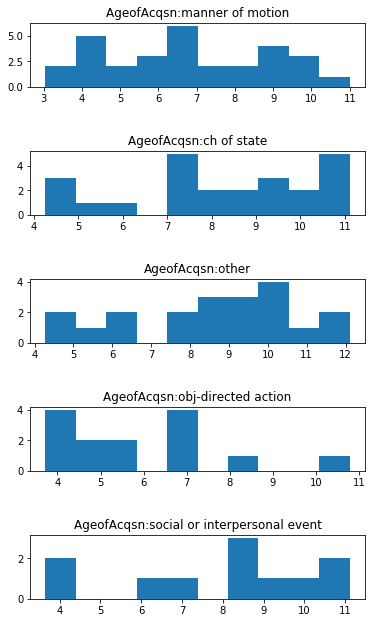

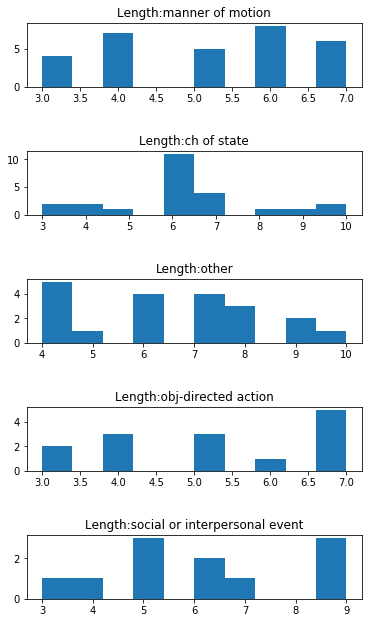

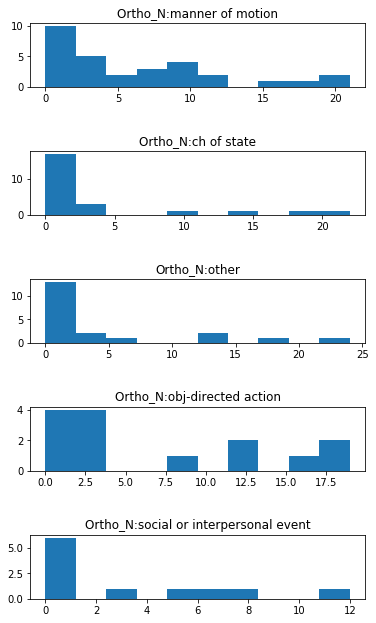

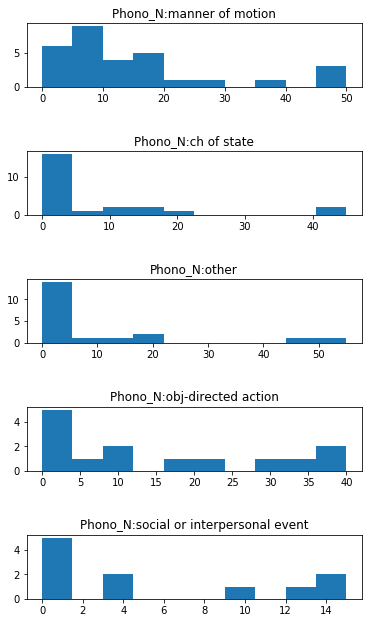

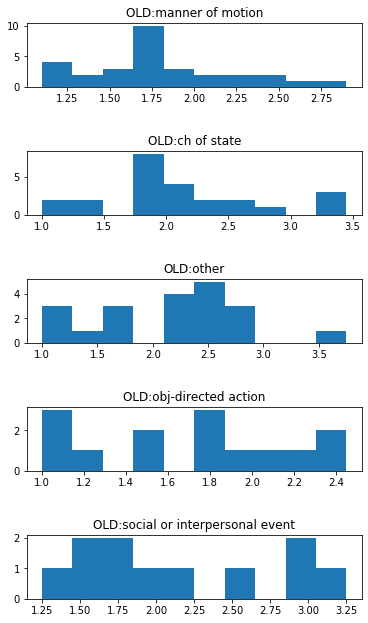

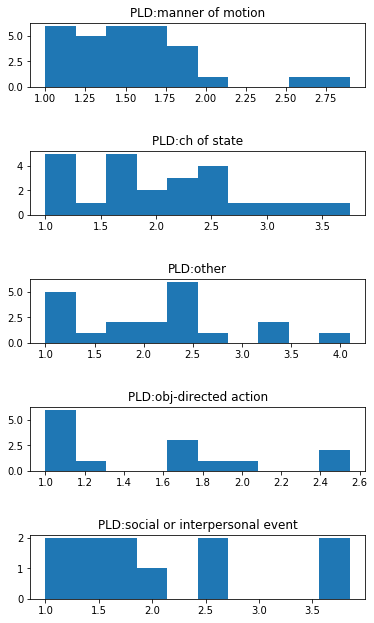

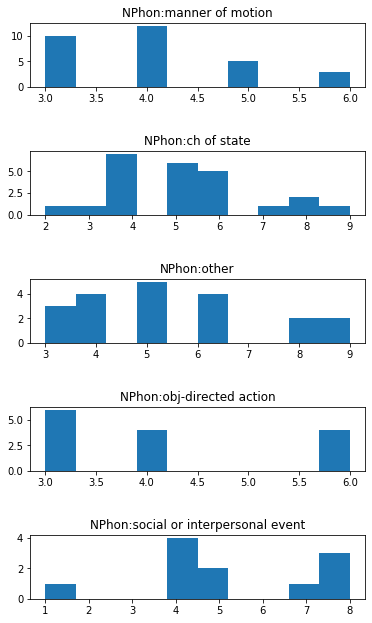

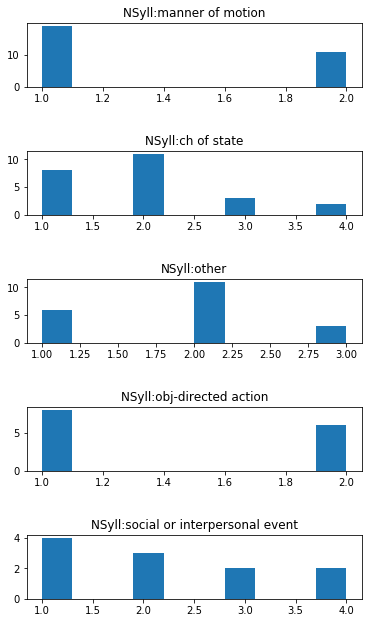

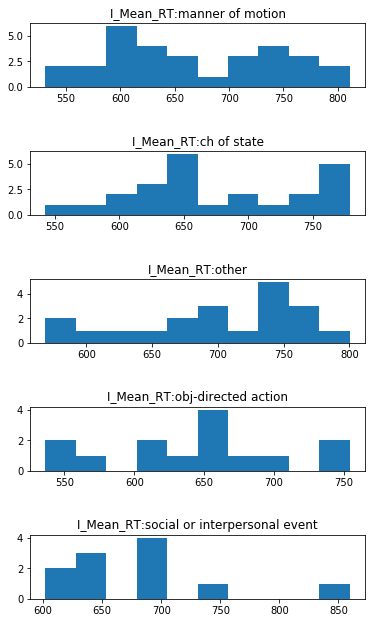

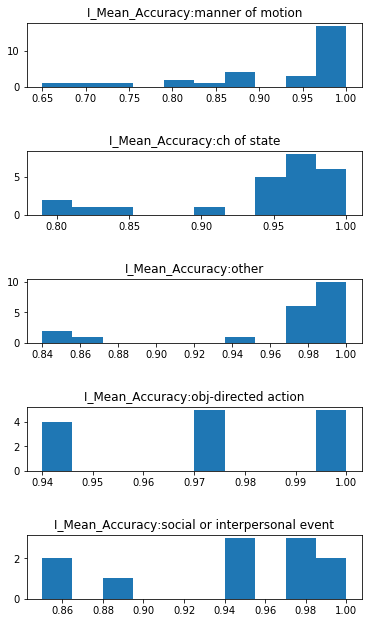

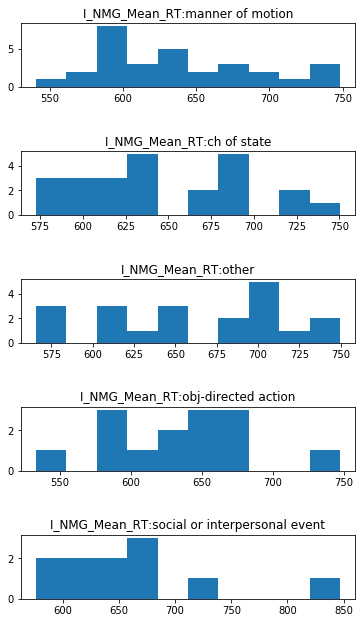

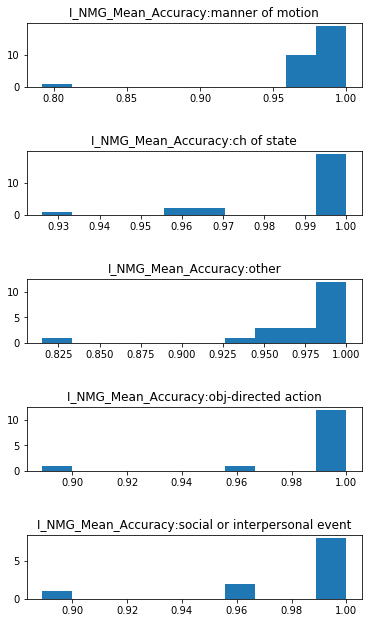

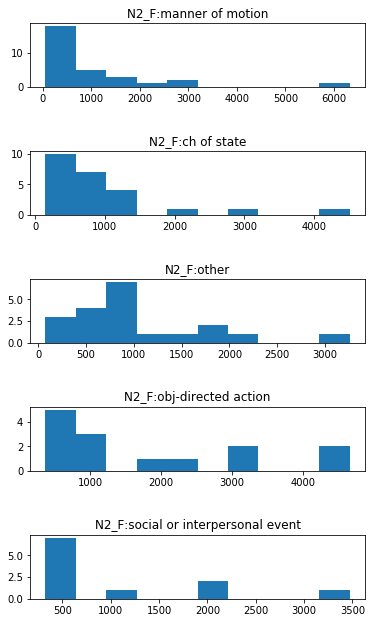

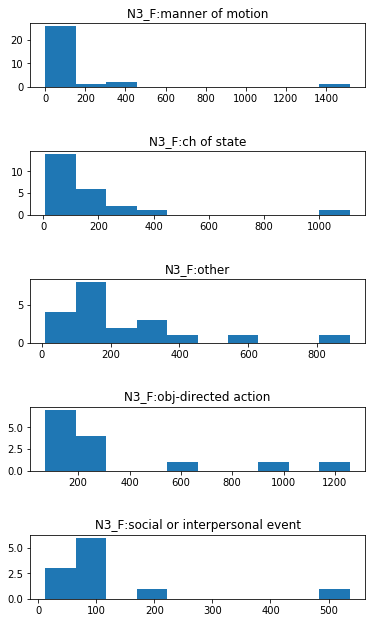

In [219]:
draw_lowlevel_distr_semclass(raw_final, 5)

In [ ]:
# def draw_histograms(df, variables, n_rows, n_cols):
#     fig=plt.figure()
#     for i, var_name in enumerate(variables):
#         ax=fig.add_subplot(n_rows,n_cols,i+1)
#         df[var_name].hist(bins=10,ax=ax)
#         ax.set_title(var_name+" Distribution")
#     fig.tight_layout()  # Improves appearance a bit.
#     plt.show()

# test = pd.DataFrame(np.random.randn(30, 9), columns=map(str, range(9)))
# draw_histograms(test, test.columns, 3, 3)